## Red Sox's dataset

----

In this notebook, we'll perform data wrangling and exploratory data analysis over the Red Sox's dataset to answer the following questions: 

- How do the prices consumers pay for tickets change as the game date approaches (i.e., as the number of days between the transaction date and game date declines)? 
- How does this dynamic pattern change across years?



### Reading data
Here we load all the necessary libraries, read every file, and concatenate the different data frames within one single data frame. We'll additionally append the year variable and create a new *transaction_date* variable with an actual date (assuming the structure of *transaction_date* is month_day). 

- First select: year variable, aux_transaction_date: [month, day], aux_game_date: [month (MMM), day].
- Second select: create transaction_date with the date variable of the transaction.
- Third select: create game_date with the date of the game.
- Remove redundant columns.
- Rename output columns.
- Cache the data.

In [ ]:
!apt-get install openjdk-8-jdk -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"

import findspark
from google.colab import drive, auth
findspark.init("spark-3.0.2-bin-hadoop2.7") # SPARK_HOME
from pyspark.sql import SparkSession
spark =  SparkSession.builder.master("local[*]").getOrCreate()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Python
import os, re
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Spark
import pyspark.sql.functions as F
from pyspark.sql.types import *


# Iterate over each file in the datapath
# hdfs dfs -find /data/sandboxes/fusa/data/ -name 'redsox'
DATA_PATH = 'drive/MyDrive/2021Q1_DSF_contents/DATA'

for i, file in enumerate(os.listdir(DATA_PATH)):
    # Extract year from file's name
    year = re.findall(r'([0-9]+)', file)[0]
    # Read data
    year_data = spark.read.csv(f'{DATA_PATH}/{file}', 
                               inferSchema=True, 
                               header=True,
                               sep=',')
    # Create transaction date
    print(f'processing data for year: {year}')
    year_data = (year_data
                     .withColumn('split_transact', F.split(F.col('transaction_date'), '_'))
                     .withColumn('split_game', F.split(F.col('gamedate'), ' '))
                     .withColumn('transact_date', 
                                 F.to_date(F.concat(F.lit(year), 
                                                    F.lit('-'), 
                                                    F.col('split_transact')[0],
                                                    F.lit('-'),                                    
                                                    F.col('split_transact')[1])))
                     .withColumn('game_date', 
                                 F.to_date(F.concat(F.lit(year), 
                                                    F.lit('-'),
                                                    F.col('split_game')[0],
                                                    F.lit('-'),
                                                    F.col('split_game')[1]
                                                   ), format='yyyy-MMM-dd'))
                     .drop('split_transact', 
                           'split_game', 
                           'transaction_date', 
                           'gamedate',
                           'gamemonth'))
    if not i: 
        all_data = year_data
    else:
        all_data = all_data.union(year_data)
                
print('\nCaching results.\n')
all_data = all_data.cache()

if all_data.storageLevel.useMemory: 
    print('"all_data" is cached!')

processing data for year: 2009
processing data for year: 2010
processing data for year: 2012
processing data for year: 2011

Caching results.

"all_data" is cached!


### Data integrity validation


First, we check if the datatypes are as expected: 


We can see that *transaction_date* and *game_date* are date types as expected. The rest of the variables look fine. 

Now that we've created two date type variables, we want to verify that all the date related variables are coherent. Namely, we want to validate that: 

* *days_from_transaction_until_game* matches the date difference (if not we update the value).
* *weekend_game* is in fact a weekend. 

We begin by checking *days_from_transaction_until_game*. We do this by comparing the values of the variable with the output of the datediff function between *game_date* and *transaction_date*.

In [ ]:
(all_data
 .select(F.datediff(F.col('game_date'), 
                    F.col('transact_date')).alias('computed_days'),
         F.col('days_from_transaction_until_game').alias('given_days'))
 .withColumn('mismatch_days', F.col('given_days')-F.col('computed_days'))
 .groupBy(F.col('mismatch_days'))
 .agg(F.count('*').alias('freq'))
).toPandas().set_index('mismatch_days').sort_values('freq').freq.plot.bar()


Now let us check if *weekend_game* variable is correct. To do this, we extract the day of the week from game_date, verify if it is either Saturday or Sunday and compare the output column with *weekend_game*. 

In [ ]:
(all_data
 .select(
     F.when(F.date_format(F.col('game_date'), 'E').isin(['Fri', 'Sat', 'Sun']), 1)
     .otherwise(0).alias('computed_weekend'), 
     F.col('weekend_game').alias('given_weekend'),
     F.col('game_date')
 )
 .filter(F.col('computed_weekend') != F.col('weekend_game'))
).show(5)

Almost 80% of the values match. After randomly sampling some dates and checking the values manually, we arrive at the conclusion that *weekend_game_new* has the correct values, so we update the variable. 

In [ ]:
all_data = all_data.withColumn('weekend_game', F.when(F.date_format(F.col('game_date'), 'E').isin(['Fri', 'Sat', 'Sun']), 1)
     .otherwise(0))

After the preprocessing part is done we are ready to cache the results again

In [ ]:
all_data = (all_data
            .withColumn('days_from_transaction_until_game',
                        F.datediff(F.col('game_date'), 
                                   F.col('transact_date')))
            .withColumn('weeks_til_game', F.ceil(F.col('days_from_transaction_until_game') / 7)))
all_data.show(5)

In [ ]:
all_data = all_data.cache()

### Exploratory data analysis

First, we want to check what variables affect the price paid by the user as the date to the game approaches. To do this, we compute the unitary price per ticket, then we extract the mean and median (to be able to detect outliers and have a more robust estimator) of the price paid by the consumers, and the mean number of tickets bought (maybe the quantity allows us to detect sales). We obtain these statistics grouping by the rest of the variables.

In [ ]:
eda_data = (all_data
 .groupBy(F.col('sectiontype'),
          F.col('team'),
          F.col('day_game'),
          F.col('weekend_game'), 
          F.col('weeks_til_game'))
 .agg(F.round(F.avg(F.col('price_per_ticket')), 2).alias('mean_price'), 
      F.expr('percentile_approx(price_per_ticket, .5)').alias('median_price'), 
      F.round(F.stddev(F.col('price_per_ticket')), 2).alias('std_price'))
).toPandas()

eda_data.head()

,sectiontype,day_game,weekend_game,team,weeks_from_transaction_unitl_game,mean_price_per_ticket,median_price_per_ticket,mean_n_tickets
0,DUGOUTBOX,0.0,0,ATL,14,429.00,429.0,2.00
1,DUGOUTBOX,0.0,0,SEA,8,327.00,327.0,2.00
2,FamilyGS,0.0,0,NYM,16,99.00,99.0,2.00
3,FamilyGS,1.0,0,BAL,7,69.00,58.0,3.67
4,FieldBox,0.0,0,CWS,18,258.75,234.0,3.50


In [ ]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", 'LEGACY')

Since the bulk of the computations is done in a distributed fashion with Spark, we can now read the results into a local pandas data frame to perform specific graphics. First, we want to understand which variables affect the most the price of the ticket. Thus we plot the evolution of the cost of the ticket with the number of days to the event. In the first plot, we also plot the effects of *section type* and *weekend_game*, whereas in the second plot we measure the impact of *team* and *weekend_game*.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

section_data = (eda_data
 .groupby(['sectiontype', 'weeks_til_game', 'weekend_game'])
 .agg(mean_median_price=pd.NamedAgg('median_price', lambda x: np.mean(x)))
 .reset_index()
 .sort_values('weeks_til_game', ascending=True))

sns.lineplot(x='weeks_til_game', 
             y='mean_median_price', 
             hue='sectiontype',
             style='weekend_game',
             data=section_data,
             ax=ax)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

section_data = (eda_data_pd
 .groupby(['sectiontype', 'weeks_til_game', 'weekend_game'])
 .agg(mean_median_price=pd.NamedAgg('median_price', lambda x: np.mean(x)))
 .reset_index()
 .sort_values('weeks_til_game', ascending=True))

sns.lineplot(x='weeks_til_game', 
             y='mean_median_price', 
             hue='sectiontype',
             style='weekend_game',
             data=section_data,
             ax=ax)
plt.show()

We can see that in both plots that most of the time-series are relatively stable, but there are some events that have huge outliers. Let us study further the distribution of prices across these variables.  

#### Section

First, we check the distribution of prices along the different sections with the effect of the weekend game. (violinplot)

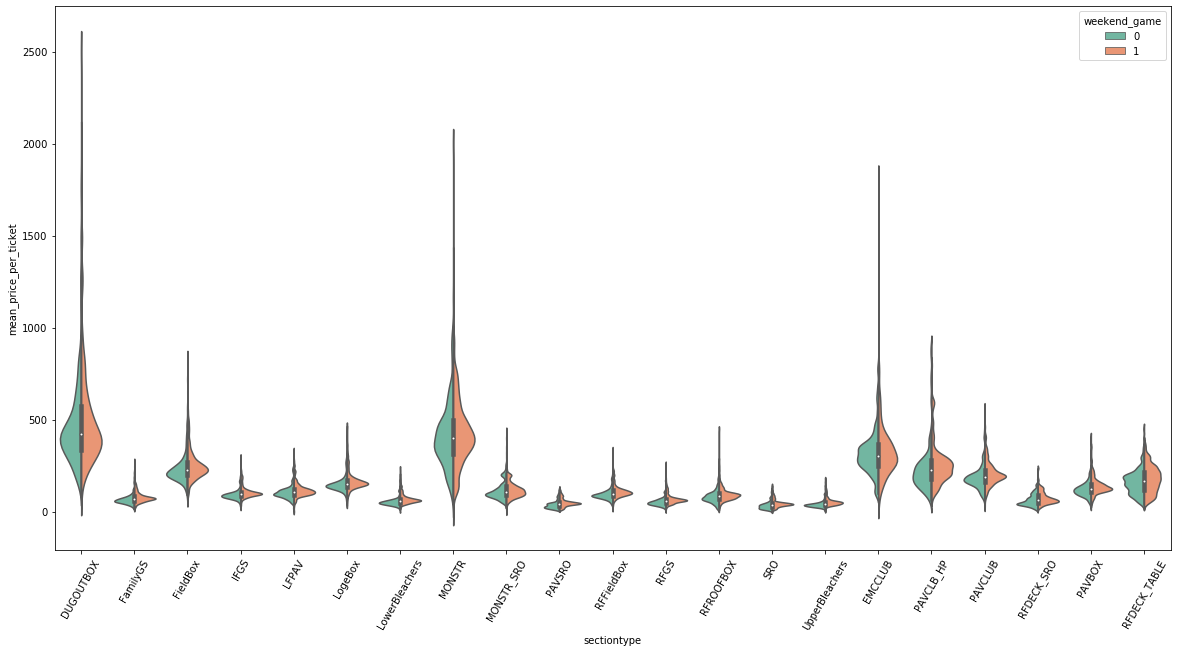

In [ ]:
quant_var = 'median_price'
cat_vars = 'sectiontype'
plt.figure(figsize=(20, 10))
sns.violinplot(x=cat_vars, y=quant_var, hue='weekend_game', palette='Set2', split=True, bw=.2, data=eda_data_pd)
plt.xticks(rotation=60)
plt.show()

We do the same for the variable day game.

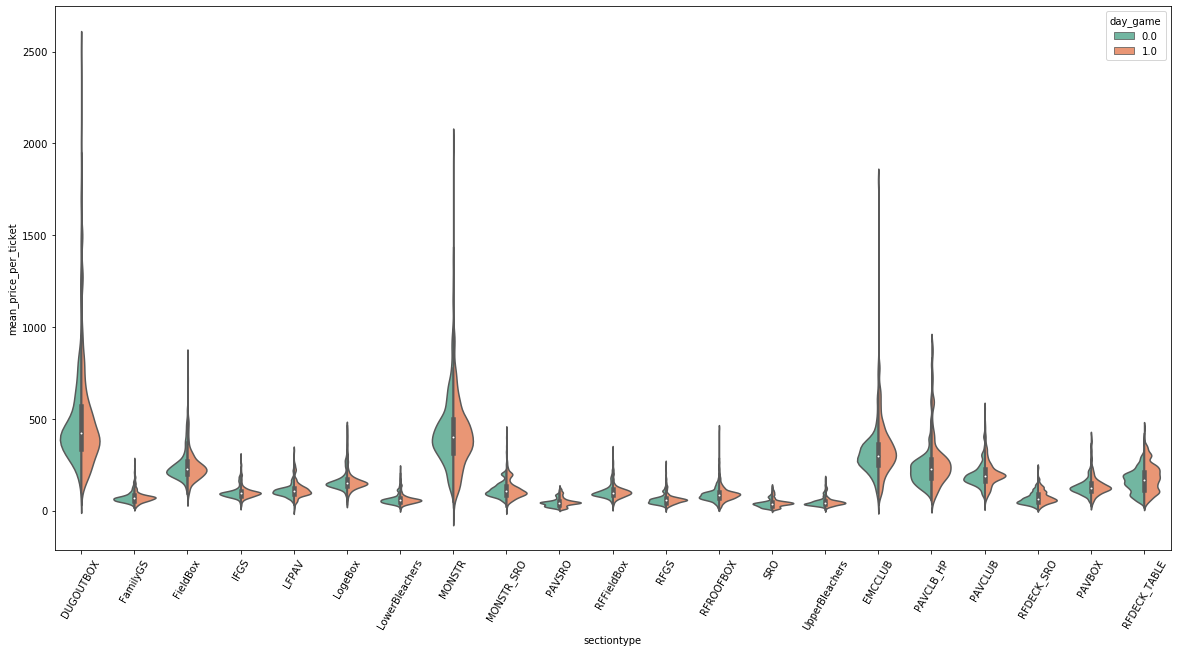

In [ ]:
eda_data.head()

In [ ]:
eda_data = (all_data
 .groupBy(F.col('sectiontype'),
          F.col('team'),
          F.col('day_game'),
          F.col('weekend_game'), 
          F.col('weeks_til_game'))
 .agg(F.round(F.avg(F.col('price_per_ticket')), 2).alias('mean_price'), 
      F.expr('percentile_approx(price_per_ticket, .5)').alias('median_price'), 
      F.round(F.stddev(F.col('price_per_ticket')), 2).alias('std_price'))
).toPandas()

eda_data.head()

What is your interpretation? (think for some minutes).


We can observe that most sections are very concentrated concerning their prices. This suggests that additional factors such as the days from the transaction won't change the prices very much. However, there are some interesting sections that do posses high variability. We'll use those sections to understand better what is changing their prices. To do this, we filter the top 35% percent of the sections according to median_price_per_ticket variance.

In [ ]:
from pyspark.sql import Window




+------------+---------------------------+--------------+
| sectiontype|var_median_price_per_ticket|var_percentile|
+------------+---------------------------+--------------+
|   DUGOUTBOX|                      278.2|           1.0|
|      MONSTR|                     188.97|          0.95|
|     EMCCLUB|                     161.64|           0.9|
|   PAVCLB_HP|                     134.28|          0.85|
|    FieldBox|                      88.12|           0.8|
|RFDECK_TABLE|                       74.9|          0.75|
+------------+---------------------------+--------------+



Filter *eda_data* with *max_var* entries.

In [ ]:
eda_data.show()

+-----------+--------+------------+----+---------------------------------+---------------------+-----------------------+--------------+
|sectiontype|day_game|weekend_game|team|weeks_from_transaction_unitl_game|mean_price_per_ticket|median_price_per_ticket|mean_n_tickets|
+-----------+--------+------------+----+---------------------------------+---------------------+-----------------------+--------------+
|  DUGOUTBOX|       0|           0| ATL|                               14|                429.0|                  429.0|           2.0|
|  DUGOUTBOX|       0|           0| SEA|                                8|                327.0|                  327.0|           2.0|
|   FieldBox|       0|           0| CWS|                               18|               258.75|                  234.0|           3.5|
|   FieldBox|       0|           1| ATL|                                9|               271.12|                  287.0|          2.25|
|   FieldBox|       1|           1|  KC|        

We'll perform an analysis of the variability of prices per *event* (event = game_date+team) in order to understand which teams are the ones that experience the largest variability in prices and when does this happen. To perform this analysis, we are going to filter the top .25% of events.

#### Event

Now we can check different statistics associated with the events that have very large variability in their prices. Remember to extract results proportional to the number of games. 

In [ ]:
# Obtener el top 10 de las secciones con mayor variabilidad.
# Filtrar resultados para ese top.
# Definir variable evento (equipo + dia_del_juego).
# Obtener el top 25% de los eventos con mayor variabilidad.
# Obtener el porcentaje de veces que cada equipo aparece en el top de eventos.
# Obtener el porcentaje de veces que cada mes aparece en el top de eventos.
from pyspark.sql import Window

ws = Window.orderBy(F.col('std_price').desc())

high_var_sec = (eda_data
 .groupBy(F.col('sectiontype'))
 .agg(F.stddev(F.col('median_price')).alias('std_price'))
 .withColumn('top_sections', F.dense_rank().over(ws))
 .filter(F.col('top_sections') <= 10))


h_eda_data = (all_data
 .withColumn('event', F.concat(F.col('team'), F.lit('|'), F.col('game_date')))
 .join(high_var_sec, on='sectiontype', how='left_semi'))

h_eda_data.show()

+----+-------------+------------+----------+
|team|max_var_count|global_count|prop_count|
+----+-------------+------------+----------+
|  TB|            9|       54627|   1.65E-4|
| DET|            4|       22046|   1.81E-4|
| BAL|            2|       48299|    4.1E-5|
| CWS|            1|       15716|    6.4E-5|
| TOR|            5|       37543|   1.33E-4|
|  KC|            1|       22232|    4.5E-5|
| LAA|            5|       15685|   3.19E-4|
| LAD|            3|        5434|   5.52E-4|
| MIA|            2|        1988|  0.001006|
|  SD|            2|        4728|   4.23E-4|
| NYY|           34|       59632|    5.7E-4|
| MIN|            3|       12379|   2.42E-4|
| ATL|            2|        8551|   2.34E-4|
| PHI|            1|        6911|   1.45E-4|
| FLA|            1|        2994|   3.34E-4|
| TEX|            4|       25549|   1.57E-4|
| CHI|            3|        6779|   4.43E-4|
+----+-------------+------------+----------+



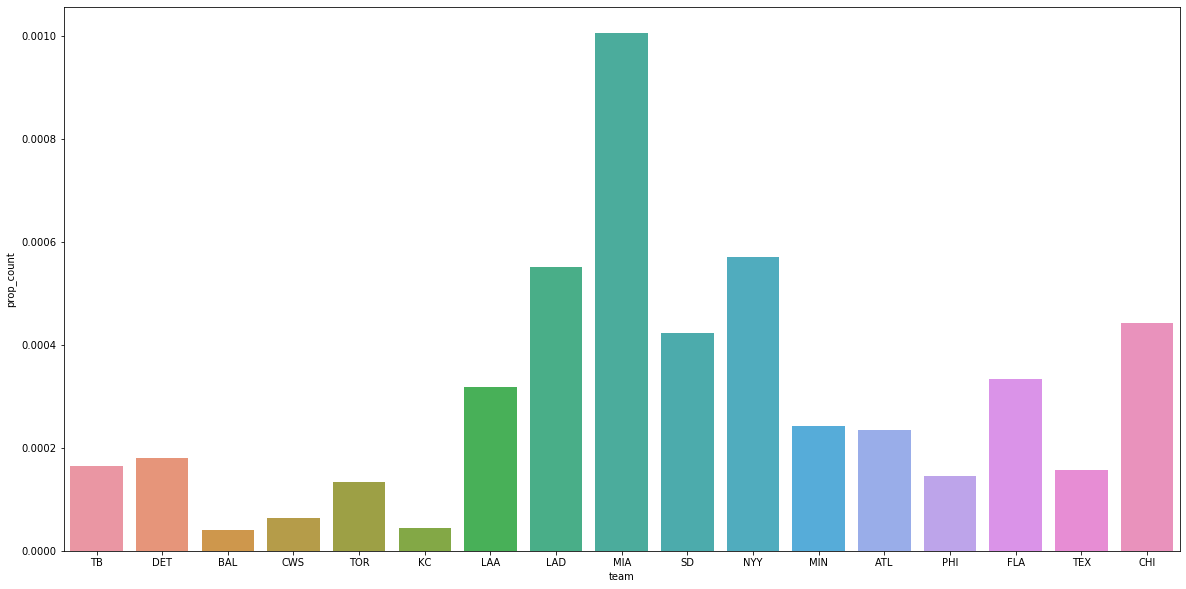

In [ ]:
relev_count = (relevant_events
               .withColumn('team', F.split(F.col('event'), '\|')[0])
               .groupBy('team')
               .agg(F.count('*').alias('relev_freq')))

abs_count = (all_data
             .groupBy('team')
             .agg(F.count('*').alias('abs_freq')))

team_rev_prop = (relev_count
                 .join(abs_count, how='left', on='team')
                 .withColumn('prop_relev', F.col('relev_freq')/F.col('abs_freq')))

fig, ax = plt.subplots(figsize=(12, 8))

team_data = (team_rev_prop
             .select(F.col('team'), F.col('prop_relev'))
             .orderBy(F.col('prop_relev').desc())
             .toPandas())

sns.barplot(x='team', y='prop_relev', data=team_data, ax=ax)
plt.show()

Filter *max_var_section* with *max_var* entries

In [ ]:
relev_count = (relevant_events
               .withColumn('month', F.month(F.to_date(F.split(F.col('event'), '\|')[1])))
               .groupBy('month')
               .agg(F.count('*').alias('relev_freq')))

abs_count = (all_data
             .withColumn('month', F.month(F.col('game_date')))
             .groupBy('month')
             .agg(F.count('*').alias('abs_freq')))

month_rev_prop = (relev_count
                 .join(abs_count, how='left', on='month')
                 .withColumn('prop_relev', F.col('relev_freq')/F.col('abs_freq')))

fig, ax = plt.subplots(figsize=(12, 8))

month_data = (month_rev_prop
             .select(F.col('month'), F.col('prop_relev'))
             .orderBy(F.col('prop_relev').desc())
             .toPandas())

sns.barplot(x='month', y='prop_relev', data=month_data, ax=ax)
plt.show()

+----+-----------+--------+------------+---------------------------------+---------------------+-----------------------+--------------+
|team|sectiontype|day_game|weekend_game|weeks_from_transaction_unitl_game|mean_price_per_ticket|median_price_per_ticket|mean_n_tickets|
+----+-----------+--------+------------+---------------------------------+---------------------+-----------------------+--------------+
| ATL|  DUGOUTBOX|       0|           0|                               14|                429.0|                  429.0|           2.0|
| CWS|   FieldBox|       0|           0|                               18|               258.75|                  234.0|           3.5|
| ATL|   FieldBox|       0|           1|                                9|               271.12|                  287.0|          2.25|
|  KC|   FieldBox|       1|           1|                               12|               326.67|                  348.0|           2.0|
| FLA|     MONSTR|       0|           0|        

In [ ]:
max_var_teams.show()

+-------------+-------------------+------------------+----+
|        event|st_price_per_ticket|    std_percentile|team|
+-------------+-------------------+------------------+----+
| 2012-04-16TB| 263.89728115790246|               1.0|  TB|
|2010-04-05NYY| 222.61940699469923|0.9969325153374233| NYY|
|2012-04-20NYY| 165.88714176989035|0.9938650306748467| NYY|
|2011-08-05NYY| 159.48910411083816|  0.99079754601227| NYY|
|2011-08-06NYY| 151.23304349650172|0.9877300613496932| NYY|
|2012-09-13NYY| 148.12696720937905|0.9846625766871165| NYY|
|2011-04-08NYY| 138.71495030679839|0.9815950920245399| NYY|
|2010-04-08NYY|  137.7837309661976|0.9785276073619632| NYY|
|2009-08-21NYY|  133.4324854246762|0.9754601226993865| NYY|
|2010-04-04NYY|  133.1468922885227|0.9723926380368099| NYY|
|2009-08-22NYY| 129.48308077557394|0.9693251533742331| NYY|
|2012-07-07NYY|  128.1649398274136|0.9662576687116564| NYY|
| 2012-09-25TB| 122.22862473379806|0.9631901840490797|  TB|
|2010-10-01NYY| 119.69946636971295|0.960

In which month games with high variability tend to cluster?

+-----+-------------+---------+--------------------+
|month|max_var_count|tot_count|          prop_count|
+-----+-------------+---------+--------------------+
|    6|           16|    76017|2.104792349079811E-4|
|    5|            5|    91126|5.486908236946645E-5|
|    9|           12|    43302|2.771234585007621E-4|
|    4|           14|    72379|1.934262700507053E-4|
|    8|           20|    82809|2.415196415848518...|
|    7|           12|    82775|1.449713077620054...|
|   10|            3|     4763|6.298551333193366E-4|
+-----+-------------+---------+--------------------+



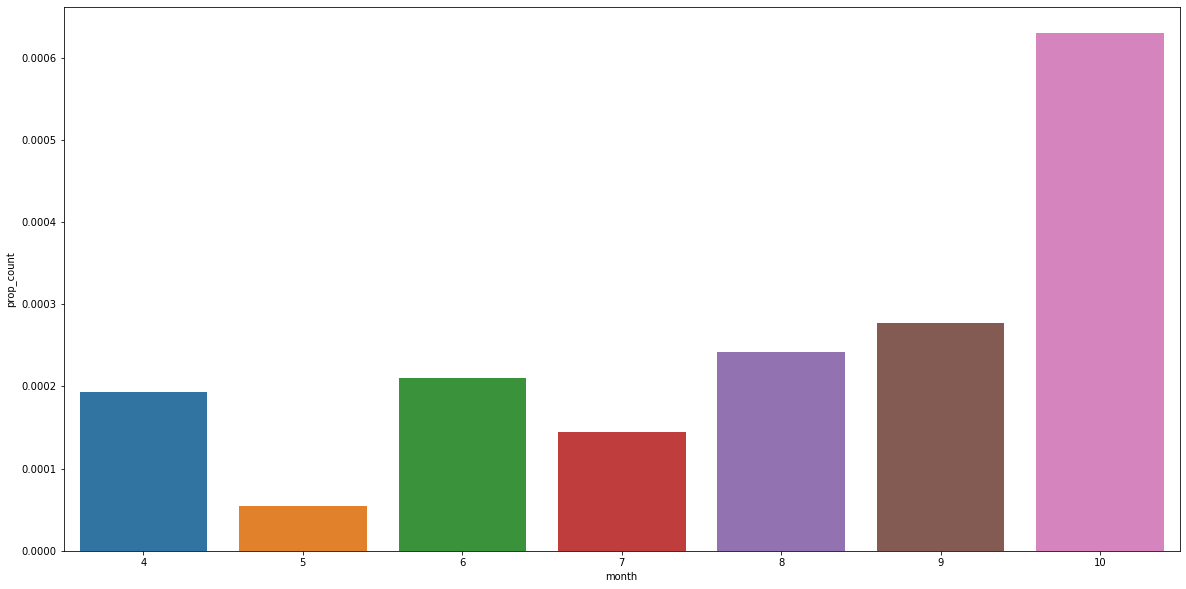

Finally we would like to study the distribution of max and min prices along the days to the event. For each event, extract the date of the max, min prize as well as the difference in days between this two dates. Hint (F.struct)

In [ ]:
max_var_teams
high_var_sec

In [ ]:
all_data_pd = 

In [ ]:
all_data_pd.head()

,event,season,game_date,max_date_price,min_date_price,min_max_date_diff,max_w_game,min_w_game,team
0,2009-09-28TOR,regular,2009-09-28,2009-07-24,2009-08-19,-3,10,6,TOR
1,2010-05-29KC,regular,2010-05-29,2010-04-07,2010-05-29,-7,8,0,KC
2,2010-08-20TOR,regular,2010-08-20,2010-05-10,2010-08-20,-14,15,0,TOR
3,2010-07-02BAL,regular,2010-07-02,2010-06-25,2010-06-30,0,1,1,BAL
4,2012-06-27TOR,regular,2012-06-27,2012-02-14,2012-06-04,-15,20,4,TOR


Plot the distribution of the dates extracted as well as of the differences. Extract the days to event from min prices and max prices and perform a test of hypothesis to check if they come from the same distribution. 

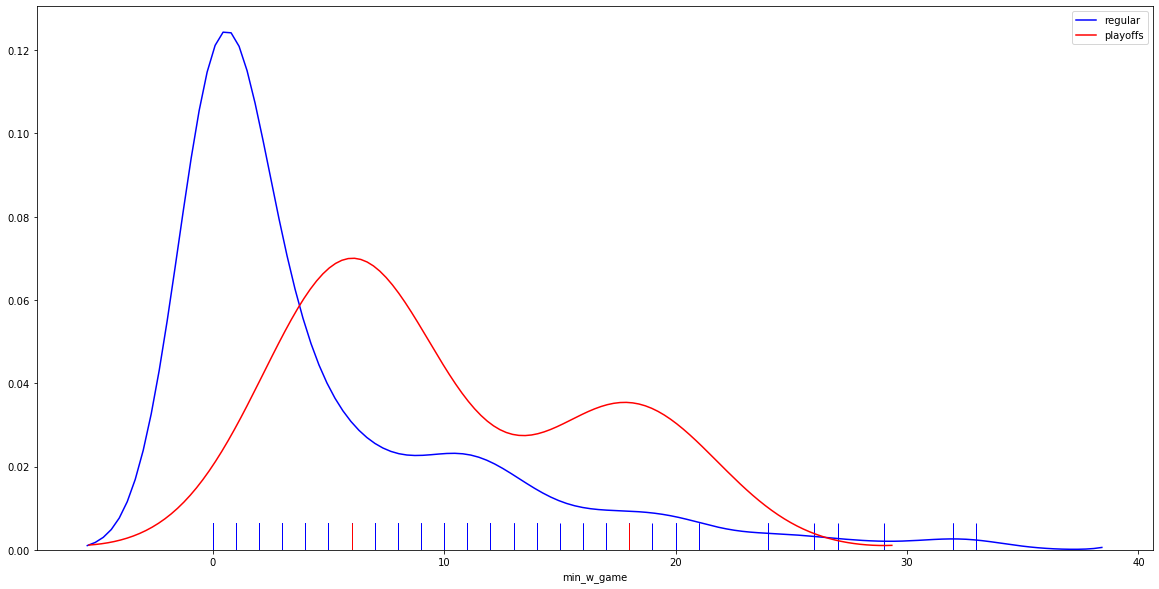

In [ ]:
pd_data = (h_eda_data
 .groupBy(F.col('event'), F.col('sectiontype'))
 .agg(
     F.min(F.struct('price_per_ticket', 'weeks_til_game')).alias('wtg_fmin'),
     F.max(F.struct('price_per_ticket', 'weeks_til_game')).alias('wtg_fmax')
 )
 .withColumn('wtg_fmin', F.col('wtg_fmin')['weeks_til_game'])
 .withColumn('wtg_fmax', F.col('wtg_fmax')['weeks_til_game'])
 .withColumn('ws', F.when(F.month(F.to_date(F.split(F.col('event'), '\|')[1])) == 10, 'ws')
            .otherwise('re'))
 .orderBy(F.col('event'))
).toPandas()

fig, ax = plt.subplots(figsize=(20, 10))
sns.distplot(pd_data['wtg_fmax'][pd_data.ws == 'ws'], rug=True, hist=False, color='blue')
sns.distplot(pd_data['wtg_fmax'][pd_data.ws == 're'], rug=True, hist=False, color='red')
plt.show()

In [ ]:
from scipy import stats



Ks_2sampResult(statistic=0.32950191570881227, pvalue=0.8251124189457922)

Conclude and give a recommendation. 

In [ ]:
## Your code goes here